# Problema de prediccion de ventas

## Planteamiento del problema y Objetivo:

El objetivo es construir un modelo de regresión simple para predecir las **ventas por producto de una tienda en particular**, que forma parte de una cadena de tiendas, y descubrir cuáles son los **principales factores que influencian dicha predicción**.

### Importando Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from scipy import stats

### Lectura de los datasets

In [2]:
data_train = pd.read_csv('../data/Train_BigMart.csv')
data_test = pd.read_csv('../data/Test_BigMart.csv')
# Identificando la data de train y de test, para posteriormente unión y separación
data_train['Set'] = 'train'
data_test['Set'] = 'test'

Combinando los dataset de *entrenamiento y test* para proceder a realizar la exploración, visualización, limpieza de datos, y posterior ingeniería de características y codificación de variables.

In [3]:
data = pd.concat([data_train, data_test], ignore_index=True, sort=False)
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train


## EDA

#### FEATURES ENGINEERING: para los años del establecimiento

In [78]:
data['Outlet_Establishment_Year'] = 2020 - data['Outlet_Establishment_Year']

## Definiendo las variables categóricas

### Resumen estadístico de variables categóricas:

#### LIMPIEZA: Unificando etiquetas para 'Item_Fat_Content'

In [81]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'low fat':  'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

Verificamos la unificación de etiquetas:

In [82]:
set(data['Item_Fat_Content'])

{'Low Fat', 'Regular'}

#### LIMPIEZA: de faltantes en el peso de los productos

In [89]:
productos = list(data[data['Item_Weight'].isnull()]['Item_Identifier'].unique())
for producto in productos:
    moda = (data[data['Item_Identifier'] == producto][['Item_Weight']]).mode().iloc[0,0]
    data.loc[data['Item_Identifier'] == producto, 'Item_Weight'] = moda

Se observa que la tienda OUT10 tiene un comportamiento similar en el nivel de ventas, que las tiendas OUT17 y OUT45 tienen coportamientos similares en sus ventas a las tiendas OUT13 y OUT46 respectivamente.

Se decide asignar a todos los valores perdidos del tamaño de las tiendas, la categoria "Small".

Tomando en consideración lo siguiente:
- El OUT10 es una tienda de tipo "Grocery Store" (lo que implica ser una tienda pequeña) y además tiene unas ventas similares al OUT19.
- El OUT17 es una tienda de tipo "Supermarket Type 1" (la mayoría de las tiendas "Supermarket Type 1" son de tamaño "Small").
- El OUT45 es una tienda de tipo "Supermarket Type 1" (la mayoría de las tiendas "Supermarket Type 1" son de tamaño "Small").

#### LIMPIEZA: de faltantes en el tamaño de las tiendas

In [105]:
#data.loc[data['Outlet_Identifier'] == 'OUT10', 'Outlet_Size'] =  'Small'
#data.loc[data['Outlet_Identifier'] == 'OUT17', 'Outlet_Size'] =  'Small'
#data.loc[data['Outlet_Identifier'] == 'OUT45', 'Outlet_Size'] =  'Small'

In [ ]:
outlets = list(data[data['Outlet_Size'].isnull()]['Outlet_Identifier'].unique())

In [106]:
for outlet in outlets:
    data.loc[data['Outlet_Identifier'] == outlet, 'Outlet_Size'] =  'Small'

Existen productos con categoría "Low Fat" que no son comestibles o que simplemente no tienen ningún contenido de grasa, para ser consistentes se asigna una nueva categoría NA (No aplica) para los tipos de productos Household, Health and Hygiene, Hard Drinks, Soft Drinks, Fruits and Vegetables:

## Features Engineering

#### FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'

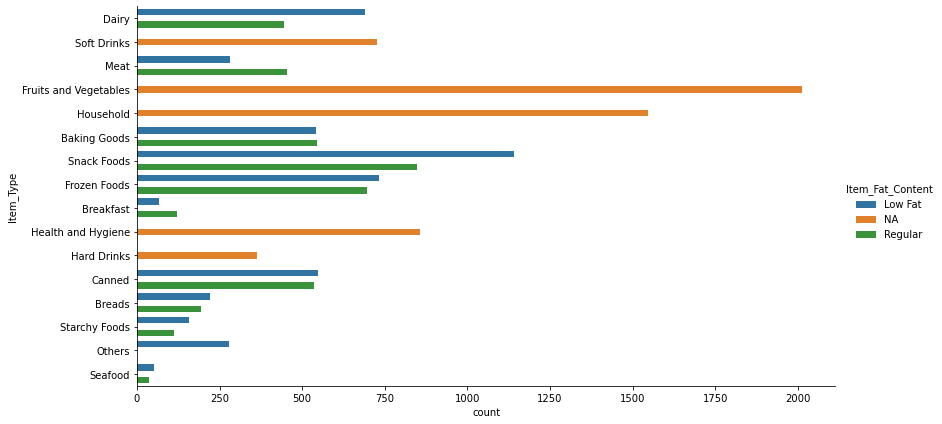

In [114]:
# FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'

data.loc[data['Item_Type'] == 'Household', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Health and Hygiene', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Hard Drinks', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Soft Drinks', 'Item_Fat_Content'] = 'NA'
data.loc[data['Item_Type'] == 'Fruits and Vegetables', 'Item_Fat_Content'] = 'NA'


#### FEATURES ENGINEERING: creando categorías para 'Item_Type'

In [121]:
# FEATURES ENGINEERING: creando categorías para 'Item_Type'
data['Item_Type'] = data['Item_Type'].replace({'Others': 'Non perishable', 'Health and Hygiene': 'Non perishable', 'Household': 'Non perishable',
 'Seafood': 'Meats', 'Meat': 'Meats',
 'Baking Goods': 'Processed Foods', 'Frozen Foods': 'Processed Foods', 'Canned': 'Processed Foods', 'Snack Foods': 'Processed Foods',
 'Breads': 'Starchy Foods', 'Breakfast': 'Starchy Foods',
 'Soft Drinks': 'Drinks', 'Hard Drinks': 'Drinks', 'Dairy': 'Drinks'})

# FEATURES ENGINEERING: asignación de nueva categorías para 'Item_Fat_Content'
data.loc[data['Item_Type'] == 'Non perishable', 'Item_Fat_Content'] = 'NA'

#### FEATURES ENGINEERING: Codificando los niveles de precios de los productos

In [127]:
print(pd.qcut(data['Item_MRP'], 4,).unique())
data['Item_MRP'] = pd.qcut(data['Item_MRP'], 4, labels = [1, 2, 3, 4])

[(185.856, 266.888], (31.288999999999998, 94.012], (94.012, 142.247], (142.247, 185.856]]
Categories (4, interval[float64, right]): [(31.288999999999998, 94.012] < (94.012, 142.247] < (142.247, 185.856] < (185.856, 266.888]]


### Codificación de variables ordinales:
Esta vez no se considera tomar las características: 'Item_Type' y 'Item_Fat_Content'

Se utiliza una copia de data para separar los valores codificados en un dataframe distinto.

In [128]:
dataframe = data.drop(columns=['Item_Type', 'Item_Fat_Content']).copy()
dataframe.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
0,FDA15,9.30,0.016047,4,OUT049,21,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,0.019278,1,OUT018,11,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,0.016760,2,OUT049,21,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,0.000000,3,OUT010,22,Small,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,0.000000,1,OUT013,33,High,Tier 3,Supermarket Type1,994.7052,train


Se decide realizar una codificación manual y no con algún método automático, para guardar el orden de los valores.  

Las variables ordinales son: ['Outlet_Size', 'Outlet_Location_Type']

In [129]:
serie_var = dataframe['Outlet_Size'].unique()
serie_var.sort()
print('Outlet_Size', ':', serie_var)

serie_var = dataframe['Outlet_Location_Type'].unique()
serie_var.sort()
print('Outlet_Location_Type', ':', serie_var)

Outlet_Size : ['High' 'Medium' 'Small']
Outlet_Location_Type : ['Tier 1' 'Tier 2' 'Tier 3']


#### FEATURES ENGINEERING: Codificación de variables ordinales

In [130]:
# Codificación de variables ordinales
dataframe['Outlet_Size'] = dataframe['Outlet_Size'].replace({'High': 2, 'Medium': 1, 'Small': 0})
dataframe['Outlet_Location_Type'] = dataframe['Outlet_Location_Type'].replace({'Tier 1': 2, 'Tier 2': 1, 'Tier 3': 0}) # Estas categorias se ordenaron asumiendo la categoria 2 como más lejos
dataframe.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Set
0,FDA15,9.30,0.016047,4,OUT049,21,1,2,Supermarket Type1,3735.1380,train
1,DRC01,5.92,0.019278,1,OUT018,11,1,0,Supermarket Type2,443.4228,train
2,FDN15,17.50,0.016760,2,OUT049,21,1,2,Supermarket Type1,2097.2700,train
3,FDX07,19.20,0.000000,3,OUT010,22,0,0,Grocery Store,732.3800,train
4,NCD19,8.93,0.000000,1,OUT013,33,2,0,Supermarket Type1,994.7052,train


#### FEATURES ENGINEERING: Codificación de variables nominales

In [131]:
dataframe = pd.get_dummies(dataframe, columns=['Outlet_Type'])
dataframe.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Set,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,9.30,0.016047,4,OUT049,21,1,2,3735.1380,train,0,1,0,0
1,DRC01,5.92,0.019278,1,OUT018,11,1,0,443.4228,train,0,0,1,0
2,FDN15,17.50,0.016760,2,OUT049,21,1,2,2097.2700,train,0,1,0,0
3,FDX07,19.20,0.000000,3,OUT010,22,0,0,732.3800,train,1,0,0,0
4,NCD19,8.93,0.000000,1,OUT013,33,2,0,994.7052,train,0,1,0,0


### Preparando data de entrenamiento y de test

In [134]:
# Eliminación de variables que no contribuyen a la predicción por ser muy específicas
dataset = dataframe.drop(columns=['Item_Identifier', 'Outlet_Identifier'])

# División del dataset de train y test
df_train = dataset.loc[data['Set'] == 'train']
df_test = dataset.loc[data['Set'] == 'test']

# Eliminando columnas sin datos
df_train.drop(['Set'], axis=1, inplace=True)
df_test.drop(['Item_Outlet_Sales','Set'], axis=1, inplace=True)

# Guardando los datasets
df_train.to_csv("train_final.csv")
df_test.to_csv("test_final.csv")

C:\Users\alexb\AppData\Local\Temp\ipykernel_23296\3328062021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['Set'], axis=1, inplace=True)
C:\Users\alexb\AppData\Local\Temp\ipykernel_23296\3328062021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['Item_Outlet_Sales','Set'], axis=1, inplace=True)


In [135]:
df_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,4,21,1,2,3735.1380,0,1,0,0
1,5.92,0.019278,1,11,1,0,443.4228,0,0,1,0
2,17.50,0.016760,2,21,1,2,2097.2700,0,1,0,0
3,19.20,0.000000,3,22,0,0,732.3800,1,0,0,0
4,8.93,0.000000,1,33,2,0,994.7052,0,1,0,0


In [136]:
df_test.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8523,20.750,0.007565,2,21,1,2,0,1,0,0
8524,8.300,0.038428,1,13,0,1,0,1,0,0
8525,14.600,0.099575,4,22,0,0,1,0,0,0
8526,7.315,0.015388,3,13,0,1,0,1,0,0
8527,13.600,0.118599,4,35,1,0,0,0,0,1


#### ENTRENAMIENTO

Métricas del Modelo:
ENTRENAMIENTO: RMSE: 1169.35 - R2: 0.5284
VALIDACIÓN: RMSE: 1146.66 - R2: 0.5526

Coeficientes del Modelo:
Intersección: 253.70
                        features  Coeficiente Estimados
0                    Item_Weight              -2.332949
1                Item_Visibility            -311.774516
2                       Item_MRP             825.276595
3      Outlet_Establishment_Year             -10.632046
4                    Outlet_Size             102.518103
5           Outlet_Location_Type              27.760861
6      Outlet_Type_Grocery Store           -1664.691331
7  Outlet_Type_Supermarket Type1             191.570173
8  Outlet_Type_Supermarket Type2            -242.596116
9  Outlet_Type_Supermarket Type3            1715.717274 



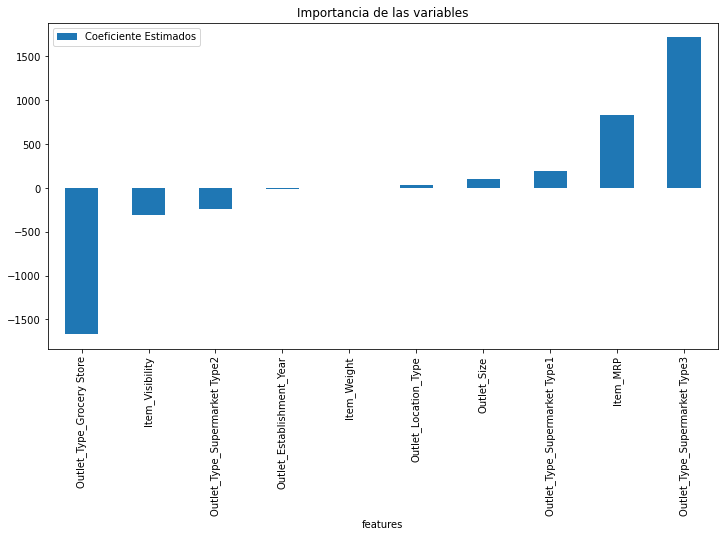

In [137]:
# Importando librerías para el modelo
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression

seed = 28
model = LinearRegression()

# División de dataset de entrenaimento y validación
X = df_train.drop(columns='Item_Outlet_Sales') #[['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type']] # .drop(columns='Item_Outlet_Sales')
x_train, x_val, y_train, y_val = train_test_split(X, df_train['Item_Outlet_Sales'], test_size = 0.3, random_state=seed)

# Entrenamiento del modelo
model.fit(x_train,y_train)

# Predicción del modelo ajustado para el conjunto de validación
pred = model.predict(x_val)

# Cálculo de los errores cuadráticos medios y Coeficiente de Determinación (R^2)
mse_train = metrics.mean_squared_error(y_train, model.predict(x_train))
R2_train = model.score(x_train, y_train)
print('Métricas del Modelo:')
print('ENTRENAMIENTO: RMSE: {:.2f} - R2: {:.4f}'.format(mse_train**0.5, R2_train))

mse_val = metrics.mean_squared_error(y_val, pred)
R2_val = model.score(x_val, y_val)
print('VALIDACIÓN: RMSE: {:.2f} - R2: {:.4f}'.format(mse_val**0.5, R2_val))

print('\nCoeficientes del Modelo:')
# Constante del modelo
print('Intersección: {:.2f}'.format(model.intercept_))

# Coeficientes del modelo
coef = pd.DataFrame(x_train.columns, columns=['features'])
coef['Coeficiente Estimados'] = model.coef_
print(coef, '\n')
coef.sort_values(by='Coeficiente Estimados').set_index('features').plot(kind='bar', title='Importancia de las variables', figsize=(12, 6))

plt.show()

## Principales variables utilizadas por el modelo:
- Con relación directa: Outlet_Type_Supermarket Type3, Item_MRP
- Con relación inversa: Outlet_Type_Grocery Store, Item_Visibility

### Aplicación del modelo en el dataset de test

In [138]:
# Predicción del modelo ajustado
data_test = df_test.copy()
data_test['pred_Sales'] = model.predict(data_test)
data_test.to_csv('data_test')
data_test.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,pred_Sales
8523,20.750,0.007565,2,21,1,2,0,1,0,0,1979.827531
8524,8.300,0.038428,1,13,0,1,0,1,0,0,1128.751306
8525,14.600,0.099575,4,22,0,0,1,0,0,0,1591.108584
8526,7.315,0.015388,3,13,0,1,0,1,0,0,2788.785512
8527,13.600,0.118599,4,35,1,0,0,0,0,1,4932.220314
